In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

In [2]:
mode_weights = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

mode_weights

mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)
x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)



all_input = []
all_output=[]
all_x=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    modeweights = np.tile(mode_weights.iloc[i,:].values, (inputData.shape[0],1))
    input_modes = np.concatenate((inputData,modeweights),axis=1)
    all_x.append(torch.tensor(inputData))
    all_input.append(torch.tensor(input_modes))
    all_output.append(torch.tensor(outputData))
    print(val)
    print(np.max(outputData))
#all_input=pd.concat(all_input)
#all_output=pd.concat(all_output
#all_input.columns=x_labels
#all_output.columns=y_labels

01
406.703
02
317.407
03
332.914
04
309.14
05
277.849
06
296.377
07
355.546
08
283.103
09
391.145
10
439.316
11
348.01
12
292.465
13
301.222
14
325.678
16
297.968
17
317.709
18
297.346
19
312.492


In [3]:
train_input=[]
test_input = []
train_output=[]
test_output = []

train_input_modes=[]
test_input_modes = []
train_output_modes=[]
test_output_modes = []

for i in range(len(meshes)):

    X=all_x[i]
    y=all_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    
for i in range(len(meshes)):

    X=all_input[i]
    y=all_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_modes.append(X_train)
    test_input_modes.append(X_test)
    train_output_modes.append(y_train)
    test_output_modes.append(y_test)


# Emulator per mesh

In [4]:
emulators=[]
for i in range(len(meshes)):
    emulators.append(GPE.ensemble(train_input[i],train_output[i],mean_func="linear",training_iter=1000))

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [6]:
emulators_CV=[]
for i in range(len(meshes)):
    emulators_CV.append(GPE.ensemble(train_input[i][:,[0,3]],train_output[i],mean_func="linear",training_iter=1000))

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [14]:
reps = 10

R2 = torch.zeros(len(meshes),reps,2)
R2_CV = torch.zeros(len(meshes),reps,2)
for i in range(len(meshes)):
    for j in range(reps):
        R2[i,j,:]=emulators[i].R2(test_input[i],test_output[i])
        R2_CV[i,j,:]=emulators_CV[i].R2(test_input[i][:,[0,3]],test_output[i])

Text(0, 0.5, '$R^2$')

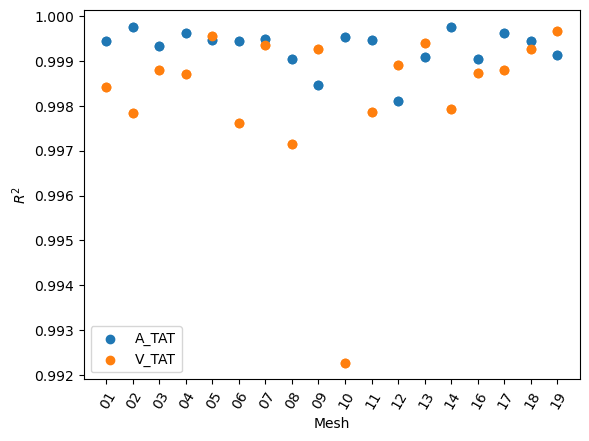

In [15]:
fig, ax = plt.subplots()


ax.scatter(meshes,R2.mean(axis=1)[:,0].detach().numpy())
plt.errorbar(meshes,R2.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2.std(axis=1)[:,0].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

ax.scatter(meshes,R2.mean(axis=1)[:,1].detach().numpy())
plt.errorbar(meshes,R2.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2.std(axis=1)[:,1].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

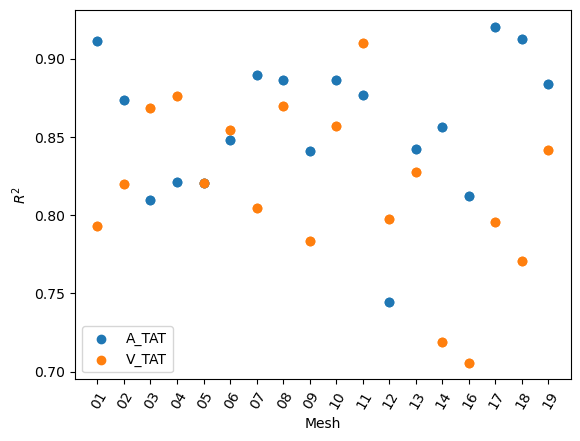

In [16]:
fig, ax = plt.subplots()


ax.scatter(meshes,R2_CV.mean(axis=1)[:,0].detach().numpy())
plt.errorbar(meshes,R2_CV.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2.std(axis=1)[:,0].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

ax.scatter(meshes,R2_CV.mean(axis=1)[:,1].detach().numpy())
plt.errorbar(meshes,R2_CV.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2.std(axis=1)[:,1].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')

In [18]:
R2 = torch.zeros(len(meshes),reps,2)
R2_std = torch.zeros(len(meshes),reps,2)
for i in range(len(meshes)):
    meanR, stdR = emulators[i].R2_sample(test_input[i],test_output[i],n=1000)
    R2[i,j,:]=meanR
    R2_std[i,j,:] = stdR

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_std = torch.tensor(R2_score.std(axis=0))


In [19]:
R2.mean(axis=1)

tensor([[0.9991, 0.9975],
        [0.9993, 0.9971],
        [0.9988, 0.9975],
        [0.9992, 0.9974],
        [0.9993, 0.9991],
        [0.9992, 0.9970],
        [0.9992, 0.9986],
        [0.9985, 0.9963],
        [0.9978, 0.9985],
        [0.9990, 0.9907],
        [0.9989, 0.9967],
        [0.9974, 0.9967],
        [0.9987, 0.9987],
        [0.9994, 0.9973],
        [0.9983, 0.9963],
        [0.9994, 0.9980],
        [0.9987, 0.9984],
        [0.9989, 0.9990]])

In [20]:
R2_std

tensor([[[0.0003, 0.0005]],

        [[0.0002, 0.0008]],

        [[0.0003, 0.0006]],

        [[0.0002, 0.0006]],

        [[0.0003, 0.0002]],

        [[0.0002, 0.0005]],

        [[0.0002, 0.0004]],

        [[0.0004, 0.0007]],

        [[0.0005, 0.0005]],

        [[0.0002, 0.0016]],

        [[0.0003, 0.0012]],

        [[0.0008, 0.0009]],

        [[0.0003, 0.0004]],

        [[0.0001, 0.0008]],

        [[0.0006, 0.0012]],

        [[0.0001, 0.0005]],

        [[0.0004, 0.0005]],

        [[0.0003, 0.0004]]])

Text(0, 0.5, '$R^2$')

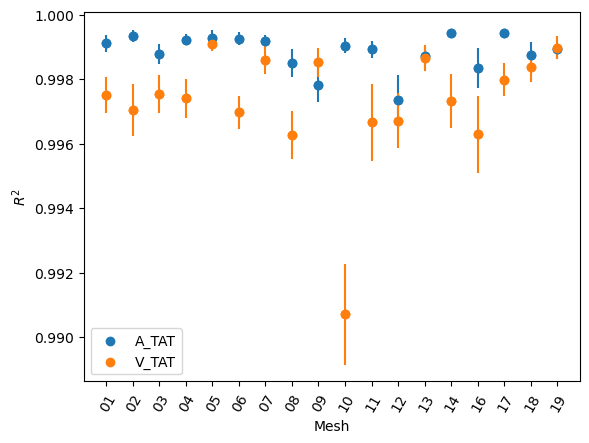

In [21]:
fig, ax = plt.subplots()


ax.scatter(meshes,R2.mean(axis=1)[:,0].detach().numpy())
plt.errorbar(meshes,R2.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2_std.mean(axis=1)[:,0].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

ax.scatter(meshes,R2.mean(axis=1)[:,1].detach().numpy())
plt.errorbar(meshes,R2.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2_std.mean(axis=1)[:,1].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')

Text(0.5, 0, 'CV_V')

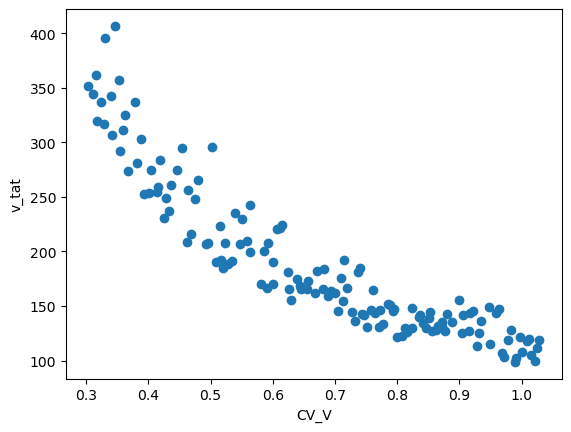

In [24]:
plt.plot(train_input[0][:,3],train_output[0][:,0],'o')
plt.ylabel('v_tat')
plt.xlabel('CV_V')

In [22]:
nn=[20,40,60,80,100,120,140]

In [23]:
R2 = torch.zeros(len(meshes),len(nn),2)
R2_std = torch.zeros(len(meshes),len(nn),2)
for i in range(len(meshes)):
    for j in range(len(nn)):
        a=np.random.choice(range(train_input[i].shape[0]),nn[j],replace=False)
        emulator=GPE.ensemble(train_input[i][a],train_output[i][a],mean_func="linear",training_iter=1000)
        meanR, stdR = emulator.R2_sample(test_input[i],test_output[i],n=1000)
        R2[i,j,:]=meanR
        R2_std[i,j,:] = stdR

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


(0.7, 1.01)

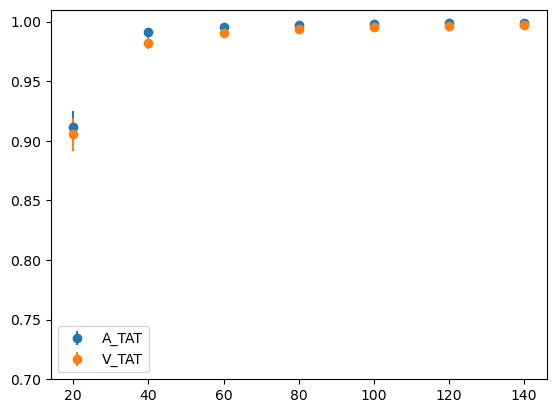

In [26]:
plt.errorbar(nn,R2.mean(axis=0)[:,0].detach().numpy(),fmt='o',yerr=R2_std.mean(axis=0)[:,0].detach().numpy())
plt.errorbar(nn,R2.mean(axis=0)[:,1].detach().numpy(),fmt='o',yerr=R2_std.mean(axis=0)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.ylim(0.7,1.01)

In [29]:
nn

[20, 40, 60, 80, 100, 120, 140]

In [30]:
R2.mean(axis=0)[:,0]

tensor([0.9116, 0.9909, 0.9954, 0.9973, 0.9983, 0.9986, 0.9988])

# Emulator trained on 277 individual meshes

In [43]:
new_mode_weights = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/shape_EP/X_shape.txt',delim_whitespace=True,header=None)

new_EP = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/shape_EP/X_EP.txt',delim_whitespace=True,header=None)

new_Y = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/shape_EP/Y.txt',delim_whitespace=True,header=None)

new_X = pd.DataFrame(np.concatenate((new_EP,new_mode_weights),axis=1))

x_labels

new_X.columns=x_labels[0:15]
new_Y.columns=y_labels

# convert all columns to numeric format
new_Y = new_Y.apply(pd.to_numeric, errors='coerce')

# identify non-numeric rows
non_numeric_rows = new_Y.isnull().any(axis=1)
non_numeric_rows=non_numeric_rows[non_numeric_rows==1]

non_numeric_rows.index

new_Y=new_Y.drop(non_numeric_rows.index)

new_X=new_X.drop(non_numeric_rows.index)

In [44]:
reps=10
t_size = np.linspace(18,162,9)
R2 = torch.zeros(t_size.shape[0],reps,2)
for i in range(t_size.shape[0]):
    for j in range(reps):
        X=torch.tensor(new_X.values)
        y=torch.tensor(new_Y.values)
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=int(180-t_size[i]),
            random_state=j
        )
        emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)
        R2[i,j,:] =emulator.R2(X_test,y_test)

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


Text(0, 0.5, '$R^2$')

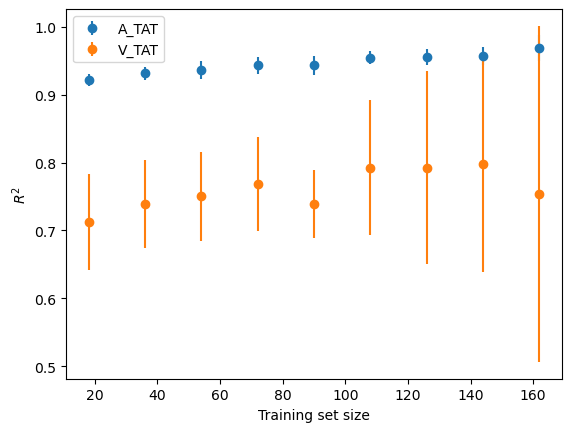

In [45]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(t_size,R2.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2.std(axis=1)[:,0].detach().numpy())
plt.errorbar(t_size,R2.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2.std(axis=1)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Training set size')
plt.ylabel('$R^2$')

# Emulator trained with 17/18 meshes and evaluated on the left out mesh

In [55]:
X.shape

torch.Size([180, 6])

In [56]:
torch.cat(all_input[:i]+all_input[i+1:])[:,0:16]

tensor([[ 0.4870,  0.3211,  6.5683,  ...,  0.1750, 23.6947,  3.5059],
        [ 0.6493,  0.3454,  4.4060,  ...,  0.1750, 23.6947,  3.5059],
        [ 0.6661,  0.4320,  7.4892,  ...,  0.1750, 23.6947,  3.5059],
        ...,
        [ 0.5298,  0.3168,  3.7916,  ...,  1.8245,  6.6634,  9.5206],
        [ 0.5367,  0.3464,  4.1096,  ...,  1.8245,  6.6634,  9.5206],
        [ 0.6656,  0.2361,  1.4870,  ...,  1.8245,  6.6634,  9.5206]],
       dtype=torch.float64)

In [57]:
(18*180)*0.8

2592.0

In [58]:
train_p = np.linspace(100,1000,10)

In [59]:
train_p

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])

In [60]:
X=torch.cat(train_input[0:17])[:,0:16]
y=torch.cat(train_output[0:17])
X_train, X_test, y_train, y_test = train_test_split(
X,
y,
train_size=1000,
random_state=j
)
emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=5000)

0
1


In [61]:
reps = 5

R2_test = torch.zeros(len(train_p),reps,2)
R2_leftout= torch.zeros(len(train_p),reps,2)
for i in range(len(train_p)):
    for j in range(reps):
        X=torch.cat(train_input_modes[0:17])[:,0:16]
        y=torch.cat(train_output_modes[0:17])
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=int(train_p[i]),
            random_state=j
        )
        emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)
        R2_test[i,j,:]=emulator.R2(torch.cat(test_input_modes[0:17])[:,0:16],torch.cat(test_output_modes[0:17]))
        R2_leftout[i,j,:] = emulator.R2(test_input_modes[17][:,0:16],test_output_modes[17]) 
        print(R2_test)

0
1
tensor([[[0.9758, 0.9745],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [

1
tensor([[[0.9758, 0.9745],
         [0.9786, 0.9763],
         [0.9815, 0.9650],
         [0.9804, 0.9610],
         [0.9692, 0.9588]],

        [[0.9948, 0.9901],
         [0.9941, 0.9889],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9758, 0.9745],
         [0.9786, 0.9763],
         [0.9815, 0.9650],
         [0.9804, 0.9610],
         [0.9692, 0.9588]],

        [[0.9948, 0.9901],
         [0.9941, 0.9889],
         [0.9950, 0.9895],
         [0.9928, 0.9845],
         [0.9954, 0.9859]],

        [[0.9959, 0.9925],
         [0.9960, 0.9941],
         [0.9975, 0.9930],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9758, 0.9745],
         [0.9786, 0.9763],
         [0.9815, 0.9650],
         [0.9804, 0.9610],
         [0.9692, 0.9588]],

        [[0.9948, 0.9901],
         [0.9941, 0.9889],
         [0.9950, 0.9895],
         [0.9928, 0.9845],
         [0.9954, 0.9859]],

        [[0.9959, 0.9925],
         [0.9960, 0.9941],
         [0.9975, 0.9930],
         [0.9970, 0.9936],
         [0.9966, 0.9934]],

        [[0.9971, 0.9954],
         [0.9974, 0.9955],
         [0.9980, 0.9945],
         [0.9980, 0.9948],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9758, 0.9745],
         [0.9786, 0.9763],
         [0.9815, 0.9650],
         [0.9804, 0.9610],
         [0.9692, 0.9588]],

        [[0.9948, 0.9901],
         [0.9941, 0.9889],
         [0.9950, 0.9895],
         [0.9928, 0.9845],
         [0.9954, 0.9859]],

        [[0.9959, 0.9925],
         [0.9960, 0.9941],
         [0.9975, 0.9930],
         [0.9970, 0.9936],
         [0.9966, 0.9934]],

        [[0.9971, 0.9954],
         [0.9974, 0.9955],
         [0.9980, 0.9945],
         [0.9980, 0.9948],
         [0.9977, 0.9951]],

        [[0.9979, 0.9962],
         [0.9980, 0.9967],
         [0.9983, 0.9961],
         [0.9984, 0.9956],
         [0.9979, 0.9956]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9758, 0.9745],
         [0.9786, 0.9763],
         [0.9815, 0.9650],
         [0.9804, 0.9610],
         [0.9692, 0.9588]],

        [[0.9948, 0.9901],
         [0.9941, 0.9889],
         [0.9950, 0.9895],
         [0.9928, 0.9845],
         [0.9954, 0.9859]],

        [[0.9959, 0.9925],
         [0.9960, 0.9941],
         [0.9975, 0.9930],
         [0.9970, 0.9936],
         [0.9966, 0.9934]],

        [[0.9971, 0.9954],
         [0.9974, 0.9955],
         [0.9980, 0.9945],
         [0.9980, 0.9948],
         [0.9977, 0.9951]],

        [[0.9979, 0.9962],
         [0.9980, 0.9967],
         [0.9983, 0.9961],
         [0.9984, 0.9956],
         [0.9979, 0.9956]],

        [[0.9984, 0.9972],
         [0.9983, 0.9967],
         [0.9985, 0.9969],
         [0.9986, 0.9969],
         [0.9985, 0.9971]],

        [[0.9986, 0.9973],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.

1
tensor([[[0.9758, 0.9745],
         [0.9786, 0.9763],
         [0.9815, 0.9650],
         [0.9804, 0.9610],
         [0.9692, 0.9588]],

        [[0.9948, 0.9901],
         [0.9941, 0.9889],
         [0.9950, 0.9895],
         [0.9928, 0.9845],
         [0.9954, 0.9859]],

        [[0.9959, 0.9925],
         [0.9960, 0.9941],
         [0.9975, 0.9930],
         [0.9970, 0.9936],
         [0.9966, 0.9934]],

        [[0.9971, 0.9954],
         [0.9974, 0.9955],
         [0.9980, 0.9945],
         [0.9980, 0.9948],
         [0.9977, 0.9951]],

        [[0.9979, 0.9962],
         [0.9980, 0.9967],
         [0.9983, 0.9961],
         [0.9984, 0.9956],
         [0.9979, 0.9956]],

        [[0.9984, 0.9972],
         [0.9983, 0.9967],
         [0.9985, 0.9969],
         [0.9986, 0.9969],
         [0.9985, 0.9971]],

        [[0.9986, 0.9973],
         [0.9984, 0.9971],
         [0.9989, 0.9971],
         [0.9985, 0.9974],
         [0.9987, 0.9974]],

        [[0.9985, 0.9972],
         [0.

1
tensor([[[0.9758, 0.9745],
         [0.9786, 0.9763],
         [0.9815, 0.9650],
         [0.9804, 0.9610],
         [0.9692, 0.9588]],

        [[0.9948, 0.9901],
         [0.9941, 0.9889],
         [0.9950, 0.9895],
         [0.9928, 0.9845],
         [0.9954, 0.9859]],

        [[0.9959, 0.9925],
         [0.9960, 0.9941],
         [0.9975, 0.9930],
         [0.9970, 0.9936],
         [0.9966, 0.9934]],

        [[0.9971, 0.9954],
         [0.9974, 0.9955],
         [0.9980, 0.9945],
         [0.9980, 0.9948],
         [0.9977, 0.9951]],

        [[0.9979, 0.9962],
         [0.9980, 0.9967],
         [0.9983, 0.9961],
         [0.9984, 0.9956],
         [0.9979, 0.9956]],

        [[0.9984, 0.9972],
         [0.9983, 0.9967],
         [0.9985, 0.9969],
         [0.9986, 0.9969],
         [0.9985, 0.9971]],

        [[0.9986, 0.9973],
         [0.9984, 0.9971],
         [0.9989, 0.9971],
         [0.9985, 0.9974],
         [0.9987, 0.9974]],

        [[0.9985, 0.9972],
         [0.

1
tensor([[[0.9758, 0.9745],
         [0.9786, 0.9763],
         [0.9815, 0.9650],
         [0.9804, 0.9610],
         [0.9692, 0.9588]],

        [[0.9948, 0.9901],
         [0.9941, 0.9889],
         [0.9950, 0.9895],
         [0.9928, 0.9845],
         [0.9954, 0.9859]],

        [[0.9959, 0.9925],
         [0.9960, 0.9941],
         [0.9975, 0.9930],
         [0.9970, 0.9936],
         [0.9966, 0.9934]],

        [[0.9971, 0.9954],
         [0.9974, 0.9955],
         [0.9980, 0.9945],
         [0.9980, 0.9948],
         [0.9977, 0.9951]],

        [[0.9979, 0.9962],
         [0.9980, 0.9967],
         [0.9983, 0.9961],
         [0.9984, 0.9956],
         [0.9979, 0.9956]],

        [[0.9984, 0.9972],
         [0.9983, 0.9967],
         [0.9985, 0.9969],
         [0.9986, 0.9969],
         [0.9985, 0.9971]],

        [[0.9986, 0.9973],
         [0.9984, 0.9971],
         [0.9989, 0.9971],
         [0.9985, 0.9974],
         [0.9987, 0.9974]],

        [[0.9985, 0.9972],
         [0.

Text(0, 0.5, '$R^2$')

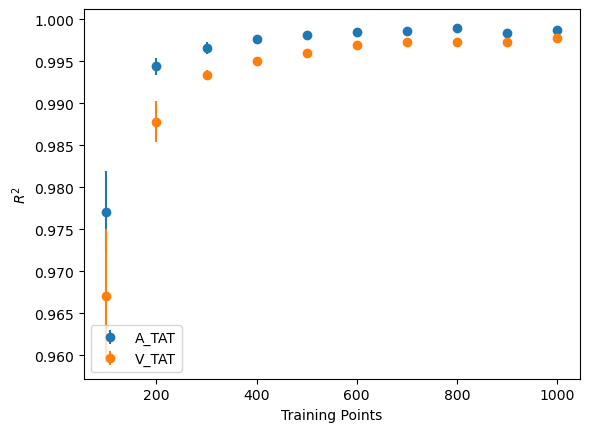

In [62]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p,R2_test.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=1)[:,0].detach().numpy())
plt.errorbar(train_p,R2_test.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=1)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Training Points')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

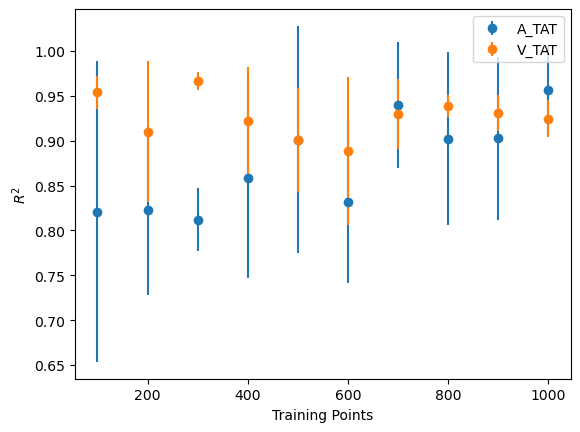

In [63]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p,R2_leftout.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=1)[:,0].detach().numpy())
plt.errorbar(train_p,R2_leftout.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=1)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Training Points')
plt.ylabel('$R^2$')

In [64]:
reps = 10

R2 = torch.zeros(len(meshes),reps,2)

for i in range(len(meshes)):
    for j in range(reps):
        X=all_x[i]
        y=all_output[i]
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=0.2,
            random_state=j
        )
        emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)
        R2[i,j,:]=emulator.R2(X_test,y_test)

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [65]:
emulator.R2(X_test,y_test)

tensor([0.9996, 0.9996], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [66]:
R2[0].shape

torch.Size([10, 2])

In [67]:
R2.mean(axis=1).shape

torch.Size([18, 2])

In [68]:
len(meshes)

18

In [69]:
R2.mean(axis=1).detach().numpy().shape

(18, 2)

Text(0, 0.5, '$R^2$')

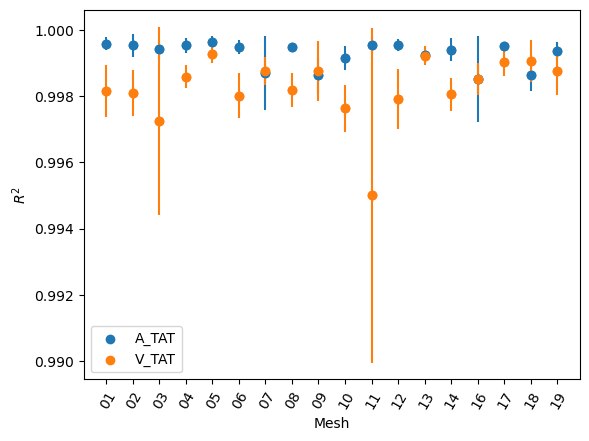

In [70]:
fig, ax = plt.subplots()


ax.scatter(meshes,R2.mean(axis=1)[:,0].detach().numpy())
plt.errorbar(meshes,R2.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2.std(axis=1)[:,0].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

ax.scatter(meshes,R2.mean(axis=1)[:,1].detach().numpy())
plt.errorbar(meshes,R2.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2.std(axis=1)[:,1].detach().numpy())
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')

In [71]:
reps = 5

R2_test = torch.zeros(len(meshes),reps,2)
R2_leftout= torch.zeros(len(meshes),reps,2)
for i in range(len(meshes)):
    for j in range(reps):
        X=torch.cat(all_input[0:i]+all_input[i+1:])[:,0:16]
        y=torch.cat(all_output[:i]+all_output[i+1:])
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=720,
            random_state=j
        )
        emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)
        R2_test[i,j,:]=emulator.R2(X_test,y_test)
        R2_leftout[i,j,:] = emulator.R2(all_input[i][:,0:16],all_output[i])

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


Text(0, 0.5, '$R^2$')

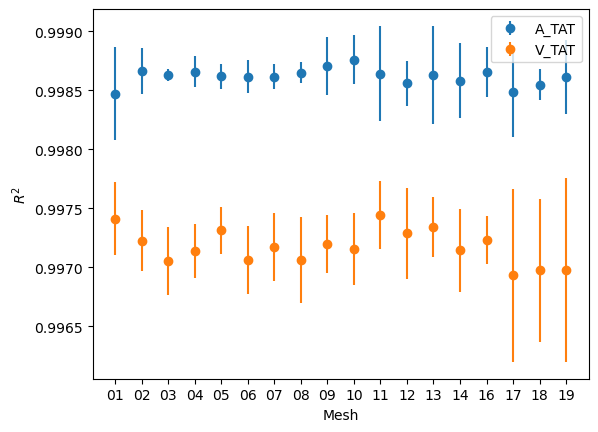

In [72]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(meshes,R2_test.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=1)[:,0].detach().numpy())
plt.errorbar(meshes,R2_test.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=1)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')

In [73]:
len(meshes)

18

In [74]:
R2_test.shape

torch.Size([18, 5, 2])

Text(0, 0.5, '$R^2$')

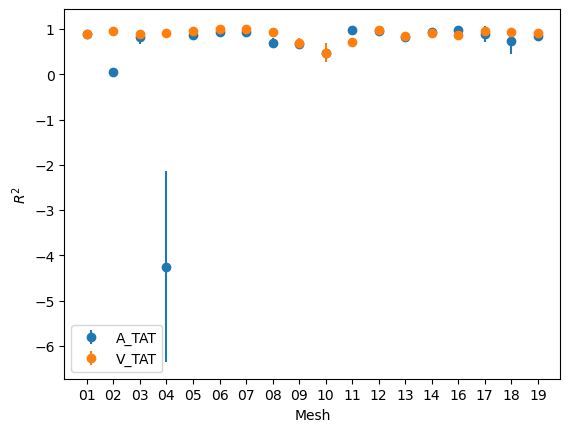

In [75]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(meshes,R2_leftout.mean(axis=1)[:,0].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=1)[:,0].detach().numpy())
plt.errorbar(meshes,R2_leftout.mean(axis=1)[:,1].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=1)[:,1].detach().numpy())
plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')

# Discrepancy

In [117]:
# x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)

# y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)

# y_labels

# inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/01/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
# outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/01/Y.txt",index_col=None,delim_whitespace=True,header=None).values

# inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/02/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
# outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/02/Y.txt",index_col=None,delim_whitespace=True,header=None).values

X0 = train_input[0]
Y0 = train_output[0]
X1 = train_input[1]
Y1 = train_output[1]


for param in emulators[0].models[0].named_parameters():
    print(f' value = {param}')

# split original dataset in training, validation and testing sets
X_train=X0
y_train=Y0
X_test=test_input[0]
y_test=test_output[0]

p = int(X1.shape[0]*0.05)
n = int(X_train.shape[0]/p)
reps = 5
MSE = np.zeros((n,reps,2))
R2 = np.zeros((n,reps,2))
MSE_p = np.zeros((n,reps,2))
R2_p = np.zeros((n,reps,2))
MSEa = np.zeros((n,reps,2))
R2a = np.zeros((n,reps,2))
for i in range(n):
    for j in range(reps):
        a=np.random.choice(range(X_train.shape[0]),(i+1)*p,replace=False)
        m0 = emulators[0].predict(X_train[a,:])
#         y_adjust = torch.tensor(y_train[a] - m0)
#         delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
#         MSE[i,j] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()
#         R2[i,j] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-y_test)**2).mean(axis=0)/y_test.var(axis=0)).detach().numpy()
        
        
        delta_1=GPE.ensemble(X_train[a,:],y_train[a],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators[1:],a=None)
        MSEa[i,j] += delta_1.MSE(X_test,y_test).detach().numpy()
        R2a[i,j] += delta_1.R2(X_test,y_test).detach().numpy()
        
        
        delta_1=GPE.ensemble(X_train[a,:],y_train[a],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators[1]],a=None)
        MSEa[i,j] += delta_1.MSE(X_test,y_test).detach().numpy()
        R2a[i,j] += delta_1.R2(X_test,y_test).detach().numpy()
        
        delta_1p = GPE.ensemble(X_train[a,:],y_train[a],mean_func="linear_cohort",training_iter=500)
        MSE_p[i,j] += delta_1p.MSE(X_test,y_test).detach().numpy()
        R2_p[i,j] += delta_1p.R2(X_test,y_test).detach().numpy()

x = np.linspace(9,162,18)

x

MSE.mean(axis=1)[0]

MSE




 value = ('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-13.0662], requires_grad=True))
 value = ('covar_module.raw_outputscale', Parameter containing:
tensor(0.4202, requires_grad=True))
 value = ('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[28.0161, 23.7628, 27.3049,  1.3106,  6.7972,  1.6804]],
       requires_grad=True))
 value = ('mean_module.weights', Parameter containing:
tensor([[ 0.0085],
        [-0.0022],
        [ 0.0057],
        [-1.8718],
        [-0.2478],
        [-0.6567]], requires_grad=True))
 value = ('mean_module.bias', Parameter containing:
tensor([2.4147], requires_grad=True))
0
1
0
1
0


AttributeError: 'ExactGPModel' object has no attribute 'mean_module'

In [ ]:
plt.plot(x,MSE.mean(axis=1))
plt.fill_between(x, MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0], y2=MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0],alpha=0.4)
plt.fill_between(x, MSE.mean(axis=1)[:,1]+MSE.std(axis=1)[:,1], y2=MSE.mean(axis=1)[:,1]-MSE.std(axis=1)[:,1],alpha=0.4)
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
#plt.yscale('log')


In [ ]:
MSE.mean(axis=1)[:,0]+MSE.std(axis=1)[:,0]

MSE.mean(axis=1)[:,0]-MSE.std(axis=1)[:,0]

delta_1p.MSE(X_test,y_test)/reps

plt.plot(x,MSE.mean(axis=1),'o') 
plt.legend(y_labels.values)

plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')

np.hstack((MSE_p,MSE))

MSE_p.mean(axis=1)[:,0]+MSE_p.std(axis=1)[:,0]

MSE_p



In [ ]:
MSE_p.std(axis=1)

In [ ]:
MSE_p.mean(axis=1)[1:,0]-MSE_p.std(axis=1)[1:,0]

In [ ]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1),MSEa.mean(axis=1)))[1:,[0,2,4]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,0]+MSE.std(axis=1)[1:,0], y2=MSE.mean(axis=1)[1:,0]-MSE.std(axis=1)[1:,0],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,0]+MSE_p.std(axis=1)[1:,0], y2=MSE_p.mean(axis=1)[1:,0]-MSE_p.std(axis=1)[1:,0],alpha=0.4)
plt.fill_between(x[1:], MSEa.mean(axis=1)[1:,0]+MSEa.std(axis=1)[1:,0], y2=MSEa.mean(axis=1)[1:,0]-MSEa.std(axis=1)[1:,0],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$','$\delta_a$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')



In [ ]:
R2_p

In [ ]:
R2a

In [ ]:
R2

In [ ]:
R2

In [ ]:
plt.plot(x[1:],np.hstack((MSE.mean(axis=1),MSE_p.mean(axis=1),MSEa.mean(axis=1)))[1:,[1,3,5]],'o') 
plt.fill_between(x[1:], MSE.mean(axis=1)[1:,1]+MSE.std(axis=1)[1:,1], y2=MSE.mean(axis=1)[1:,1]-MSE.std(axis=1)[1:,1],alpha=0.4)
plt.fill_between(x[1:], MSE_p.mean(axis=1)[1:,1]+MSE_p.std(axis=1)[1:,1], y2=MSE_p.mean(axis=1)[1:,1]-MSE_p.std(axis=1)[1:,1],alpha=0.4)
plt.fill_between(x[1:], MSEa.mean(axis=1)[1:,1]+MSEa.std(axis=1)[1:,1], y2=MSEa.mean(axis=1)[1:,1]-MSEa.std(axis=1)[1:,1],alpha=0.4)
plt.legend(['$\delta_1$','$f_1$','$\delta_a$'])
plt.ylabel('MSE')
plt.xlabel('$m$')
plt.yscale('log')



In [ ]:
plt.plot(x,np.hstack((R2.mean(axis=1),R2_p.mean(axis=1)))[:,[0,2]],'o') 
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')



In [ ]:
plt.plot(x,np.hstack((R2.mean(axis=1),R2_p.mean(axis=1)))[:,[1,3]],'o') 
plt.legend(['$\delta_1$','$f_1$'])
plt.ylabel('MSE')
plt.xlabel('$m$')



In [ ]:
plt.plot(x,MSE_p.mean(axis=1)-MSE.mean(axis=1),'o')




In [ ]:
plt.plot(x,R2_p.mean(axis=1)-R2.mean(axis=1),'o')
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$m$')



In [ ]:
MSE_p

R2_p-R2

plt.plot(x,R2.mean(axis=1),'o')
plt.legend(y_labels.values)
plt.ylabel('$R^2$')
plt.xlabel('$m$')



In [ ]:
delta_1.predict(X_test)

In [ ]:

#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE = np.zeros((n,m,2))
R2 = np.zeros((n,m,2))
reps = 5

X_train = train_input[0]
Y_train = train_output[0]
X_test = test_input[0]
X_test = test_output[0]

for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
#             emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            #m0 = emulator_0.predict(X_train[b,:])
            #y_adjust = torch.tensor(y_train[b] - m0)
            #delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            #MSE[i,k] += ((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy()/reps
            #R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps
            
            delta_1=GPE.ensemble(X_train[b,:],y_train[b],mean_func="discrepancy",training_iter=500,ref_emulator=emulators[1:],a=None)
            MSE[i,k] += delta_1.MSE(X_test,y_test).detach().numpy()/reps
            R2[i,k] += delta_1.R2(X_test,y_test).detach().numpy()/reps
            
x

y = np.linspace(9,180,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],MSE[level:,level:,1],origin='lower',levels=50)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()



In [ ]:
plt.contourf(xx[level:,level:],yy[level:,level:],R2[level:,level:,1],origin='lower',levels=50,cmap='magma')
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()





In [ ]:
plt.contourf(xx[level:,level:],yy[level:,level:],MSE[level:,level:,1],origin='lower',levels=50,cmap='magma')
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()


In [ ]:
R2cmap=R2

In [ ]:
MSEcmap=MSE

In [119]:
import time

In [128]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score


In [129]:
model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=False)),
    ('lasso', LassoCV(n_alphas=1000,max_iter=10000))
])

In [130]:
def m0_mat(y_test,emulators,x_test,output):

    m0=torch.zeros((y_test.shape[0],len(emulators)))
    for i in range(len(emulators)):
        m0[:,i]=(emulators[i].predict(x_test)[:,output]-y_train.mean(axis=0)[output])/y_train.std(axis=0)[output]


    return m0

In [131]:
def proxy(a,y_train,m0,output):
    m_t = (m0-y_train.mean(axis=0))/y_train.std(axis=0)
    y_t = (y_train-y_train.mean(axis=0))/y_train.std(axis=0)
    a=torch.tensor(a)
    res = ((a*m_t-y_t)**2).mean(axis=0).detach().numpy()
    return res[output]

In [ ]:
reps=5
nn=[5,15,25,35,45,65]
R2=torch.zeros(7,len(nn),2,reps)
ISE=torch.zeros(7,len(nn),2,reps)
Ti=torch.zeros(7,len(nn),reps)

for num, n in enumerate(nn):
    for k in range(len(emulators)):
        emulators2=emulators.copy()
        emulators2.pop(k)
        print(len(emulators2))

        X_train = train_input[k]
        y_train = train_output[k]
        X_test = test_input[k]
        y_test = test_output[k]
        
        for i in range(reps):

            b=np.random.choice(range(X_train.shape[0]),n,replace=False)

            start = time.time()
            model_f=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="linear",training_iter=500)
            end = time.time()
            R2[0,num ,:,i]+=model_f.R2(X_test,y_test)/(len(emulators))
            ISE[0,num,:,i]+=model_f.ISE(X_test,y_test)/(len(emulators))

            Ti[0,num,i]+=(end-start)/(len(emulators))


            em=np.random.randint(len(emulators2))
            start = time.time()
            model_dc_1 = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1]]))
            end = time.time()
            R2[1,num,:,i]+=model_dc_1.R2(X_test,y_test)/(len(emulators))
            ISE[1,num,:,i]+=model_dc_1.ISE(X_test,y_test)/(len(emulators))
            print(model_dc_1.R2(X_test,y_test))
            print(R2[1])

            Ti[1,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            m0 = emulators2[em].predict(X_train[b,:])
            a_d=np.zeros((y_train.shape[1],1))
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x
            a_d=torch.tensor(a_d)
            model_dc_reg = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=a_d)
            end = time.time()
            R2[2,num,:,i]+=model_dc_reg.R2(X_test,y_test)/(len(emulators))
            ISE[2,num,:,i]+=model_dc_reg.ISE(X_test,y_test)/(len(emulators))

            Ti[2,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_learned = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]])
            end = time.time()
            R2[3,num,:,i]+=model_dc_learned.R2(X_test,y_test)/(len(emulators))
            ISE[3,num,:,i]+=model_dc_learned.ISE(X_test,y_test)/(len(emulators))

            Ti[3,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_all = GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)
            end = time.time()
            R2[4,num,:,i]+=model_dc_all.R2(X_test,y_test)/(len(emulators))
            ISE[4,num,:,i]+=model_dc_all.ISE(X_test,y_test)/(len(emulators))

            Ti[4,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            a_d=torch.zeros((y_train.shape[1],len(emulators2)))
            for j in range(y_train.shape[1]):
                m0=m0_mat(y_train[b],emulators2,X_train[b],j)
                # fit to an order-3 polynomial data
                y_t=(y_train[b,j]-y_train.mean(axis=0)[j])/y_train.std(axis=0)[j]
                model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
                a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


            model_dc_lasso=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
            end = time.time()
            R2[5,num,:,i]+=model_dc_lasso.R2(X_test,y_test)/(len(emulators))
            ISE[5,num,:,i]+=model_dc_lasso.ISE(X_test,y_test)/(len(emulators))

            Ti[5,num,i]+=(end-start)/(len(emulators))

            start = time.time()
            model_dc_lasso_learned=GPE.ensemble(X_train[b,:],y_train[b,:],mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)
            end = time.time()
            R2[6,num,:,i]+=model_dc_lasso_learned.R2(X_test,y_test)/(len(emulators))
            ISE[6,num,:,i]+=model_dc_lasso_learned.ISE(X_test,y_test)/(len(emulators))

            Ti[6,num,i]+=(end-start)/(len(emulators))

17
0
1
0
1
tensor([ 0.9756, -0.0059], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ 0.0542,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0003,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<SelectBackward0>)
[0.55846679]
[1.03426511]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ 0.1610, -2.6700], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[ 0.0542,  0.0089,  0.0000,  0.0000,  0.0000],
         [-0.00

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([-12.4953,  -0.2823], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-0.5964, -0.0118, -0.2105, -0.0275, -0.7521],
         [-0.1282, -0.2855, -0.1934, -0.5130, -0.1979]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<SelectBackward0>)
[1.02041306]
[0.97052197]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([ -9.8759, -20.8809], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-0.5964, -0.5605, -0.2105, -0.0275, -0.

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([ -3.5436, -18.5314], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.0064, -0.5300, -2.2276, -0.1059, -0.7467],
         [-1.2619, -1.4487, -0.1758, -0.8377, -0.8510]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<SelectBackward0>)
[0.82026448]
[1.0055739]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-0.4037,  0.5069], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.0064, -0.5525, -2.2276, -0.1059, -0.746

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([-3.6754, -5.9991], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.4114, -0.5462, -2.2478, -0.7177, -1.3982],
         [-1.6292, -1.3727, -0.5820, -1.2750, -1.5153]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<SelectBackward0>)
[0.64065741]
[0.64888669]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-2.6344, -1.4998], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.4114, -0.6926, -2.2478, -0.7177, -1.3982

1
0
1
0
1
0
1
0
1
17
0
1
0
1
tensor([-1.5111e-02, -2.8706e+01], dtype=torch.float64,
       grad_fn=<RsubBackward1>)
tensor([[[-1.3637, -1.4592, -2.2839, -0.7451, -1.8215],
         [-3.3043, -1.4272, -0.4847, -1.7080, -2.0377]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<SelectBackward0>)
[0.80709842]
[0.92002082]
0
1
0
1
0
1
0
1
0
1
0
1
0
1
tensor([-0.0038, -0.2467], dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor([[[-1.3637, -1.4594, -2.2839, -

In [ ]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

meshes.copy

t_size = 36
reps = 5
MSE = np.zeros((len(meshes),len(meshes)-1,2))
R2 = np.zeros((len(meshes),len(meshes)-1,2))
for i in (range(len(meshes))):
    val0 = meshes[i]
    
    meshes2 = meshes.copy()
    meshes2.remove(meshes[i])
    
    inputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val0+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData_0 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val0+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    X0 = torch.tensor(inputData_0)
    Y0 = torch.tensor(outputData_0)
    X0.columns = x_labels
    Y0.columns = y_labels
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

    
    
    for j in (range(len(meshes)-1)):
        val1 = meshes2[j]
        inputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val1+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
        outputData_1 = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val1+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

        X1 = torch.tensor(inputData_1)
        Y1 = torch.tensor(outputData_1)
        X1.columns = x_labels
        Y1.columns = y_labels
        # split original dataset in training, validation and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X1,
            Y1,
            test_size=0.1,
            random_state=seed
        )
        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
            #m0 = emulator_0.predict(X_train[a,:])
            #y_adjust = torch.tensor(y_train[a] - m0)
            #delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
            #MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            #R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps
            delta_1=GPE.ensemble(X_train[a,:],y_train[a],mean_func="discrepancy",training_iter=500,ref_emulator=emulator_0,a=None)
            MSE[i,j,:] += delta_1.MSE(X_test,y_test).detach().numpy()/reps
            R2[i,j,:] += delta_1.R2(X_test,y_test).detach().numpy()/reps
MSE

MSE.mean(axis=1)

plt.plot(MSE.mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('MSE')
plt.xlabel('Mesh')



In [ ]:
y_labels[0]

In [ ]:


plt.plot(R2.mean(axis=1),'o')
plt.xticks(range(len(meshes)),meshes)
plt.ylabel('$R^2$')
plt.xlabel('$m$')
plt.legend(y_labels[0])



In [ ]:
fig, ax = plt.subplots()


ax.scatter(meshes,R2.mean(axis=1)[:,0])
plt.errorbar(meshes,R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

ax.scatter(meshes,R2.mean(axis=1)[:,1])
plt.errorbar(meshes,R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.legend(('A_TAT','V_TAT'))
plt.xlabel('Mesh')
plt.ylabel('$R^2$')